${\bf \text{Tarea 4}}$

${\bf a)}$ Claramente tenemos que el problema no es lineal en los parámetros en todo el tiempo dado el modelo:

\begin{align}
 Y_{k} &\sim f_{T} (t_{k}) + \sum_{i=0}^{p}c_{i}{t_{k}}^{i} + \epsilon\\
 f_{T}(t_{k}) &= \begin{cases}
 1 - \delta \quad t_{I} < t_{k} < t_{IV}\\ 1 \quad\quad\quad \text{e.o.c}
\end{cases}
\end{align}

ya que $f(t_{k})$ depende del tiempo, lo cual nos impide formular un modelo basado únicamente en los $c_{i}$'s. Para hacer lineal el modelo para todo $t$, lo más fácil es considerar el problema con un parámetro extra, $\delta$, el cual tenemos que estimar. Haciendo esto, el problema se nos reduce a:

\begin{align}
\begin{cases}
  y_{k} - 1 &= \delta \cdot (-1) +  \sum_\limits{i=0}^{p}c_{i}{t_{k}}^{i} + \epsilon \quad\quad  t_{I} < t_{k} < t_{IV}\\
  y_{k} - 1 &= \delta \cdot 0 + \sum\limits_{i=0}^{p}c_{i}{t_{k}}^{i} +  \epsilon \quad\quad\quad\quad \text{e.o.c}
\end{cases}
\end{align}

lo cual se reduce a la siguiente ecuación matricial:

\begin{align}
  \rightarrow \vec{y} &=  \underbrace{\begin{pmatrix}
 0 & 1 & t_{1} & t_{1}^2  & \ldots &t_{1}^p\\
 0 & 1 & t_{2} & t_{2}^2  & \ldots & t_{2}^{p}\\
  \vdots & \vdots & \vdots & \ldots & \vdots \\
 -1 & 1 & t_{I< k < IV} & t_{I< k < IV}^{2} & \ldots & t_{I< k < IV}^{p} \\
 -1 & 1 & t_{I< k + 1 < IV} & t_{I< k + 1 < IV}^{2} & \ldots & t_{I< k + 1 < IV}^{p} \\
  \vdots & \vdots & \vdots & \ldots & \vdots \\ 
 0 & 1 & t_{m-1} & t_{m-1}^2 & \ldots & t_{m-1}^{p}\\
 0 & 1 & t_{m} & t_{m}^2 & \ldots & t_{m}^{p}
\end{pmatrix}}_{X} \cdot \underbrace{\begin{pmatrix} \hat{\delta} \\ \hat{c_{0}} \\ \hat{c_{1}}\\ \vdots \\ \hat{c_{p}}\end{pmatrix}}_{\hat{\theta}} + \epsilon \\
\end{align}

Se nos piden los estimadors de ${\bf MLE}$, pero este es un problema de mínimo cuadrados (por la gaussianidad de los errores), así que trivialmente obtenemos nuestros parámetros despejando $\hat{\theta}$:


\begin{align}
(X^{T}X) \cdot \hat{\theta} &=  X^T \cdot \vec{y}\\
\rightarrow \hat{\theta} &= (X^{T}X)^{-1} X^{T} \cdot \vec{y}
\end{align}

Usaremos ${\bf numpy.linalg.solve}$ para evitar sacar la inversa del segundo paso.

${\bf b)}$

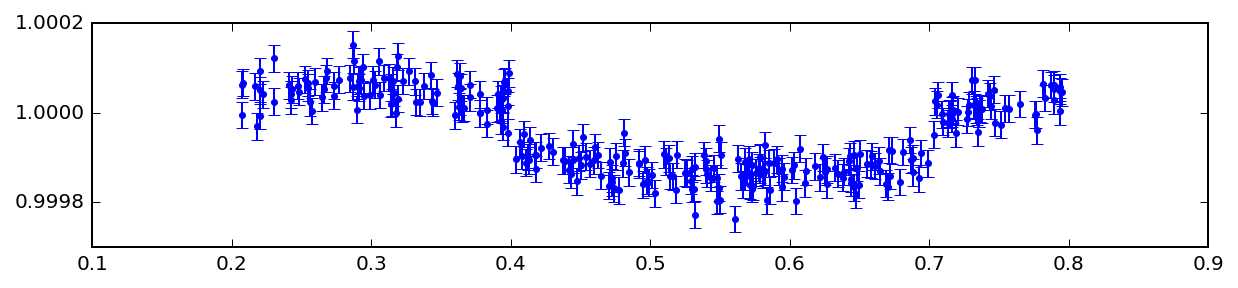

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import linalg, stats
import matplotlib.ticker as ticker
import collections
from sklearn.cross_validation import KFold
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def coef_matrix (time, p, delta):
    if delta == 'yes':
        time_I_IV = np.logical_and(time<0.7,time>0.4)
        X = np.ma.masked_array(np.zeros(len(time)), [time_I_IV]).filled(-1.)    
        for i in range(0,p+1):
            ant = np.concatenate([X,time**i],axis=0)
            X = ant
        X = X.reshape(p+2,len(time)).T
        return X
    if delta == 'no':
       X = np.ones(len(time))
       if p == 0:
          return X 
       else:
          for i in range(1,p+1) : 
              ant = np.concatenate( [X,time**i],axis=0)
              X = ant
          X = X.reshape(p+1,len(time)).T      
          return X 
    
def parameters (time,flux,p,delta):
     c_matrix = coef_matrix(time,p,delta)
     param = np.linalg.solve(np.dot(c_matrix.T,c_matrix), np.dot(c_matrix.T,flux) )
     return param, c_matrix
    
def fit(pars, matrix):
    y = np.dot(matrix,pars)
    return y
    
def chi2 (observado,modelado,dof,std):
    chi_2 =  np.dot((observado - modelado).T,(observado - modelado))/(std**2) 
    p = stats.chi2.cdf(chi_2,dof)
    p_value = 1 - p
    return chi_2, p_value

def simular_pol (pars,t,std):
    err = np.random.normal(0,std,len(t))
    y = err
    for i in range(len(pars)):
        y += pars[i]*t**i
    return y

def simular_transito(pars,t,std):
    err = np.random.normal(0,std,len(t))
    t_I_IV = np.logical_and(t<0.7,t>0.4)
    y = np.ma.masked_array(np.zeros(len(t)), [t_I_IV]).filled(-pars[0])
    y += err
    for i in range(len(pars)):
        y += pars[i]*t**i
    return y
    
      
# Parte b)
time , flux, error  = np.genfromtxt('datos.dat',skip_header=1, usecols=(0,1,2), unpack = True)

fig, ax = plt.subplots(figsize=(10, 2))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.4f'))
ax.set_xlim(0.1,0.9)
ax.errorbar(time,flux,yerr= error,fmt='.')
ax.set_yticks(2*(np.arange(3) - 1.)*10**(-4) + 1.)
plt.show()

In [2]:
# MUY IMPORTANTE EL FLUJO - 1 !!

flujo = flux -1.
params, coef_matriz = parameters(time,flujo,5,'yes')

print 'Delta: %s' % params[0]
print 'coeff values: %s' % params[1:]

#plotting everything!
t = np.linspace(0.2, 0.8, 10000)
diseno_t = coef_matrix(t,5,'yes')
 
y_fit = fit(params,diseno_t)

Delta: 0.000101000997824
coeff values: [-0.00113006  0.01220323 -0.04505635  0.07422477 -0.05635102  0.0162397 ]


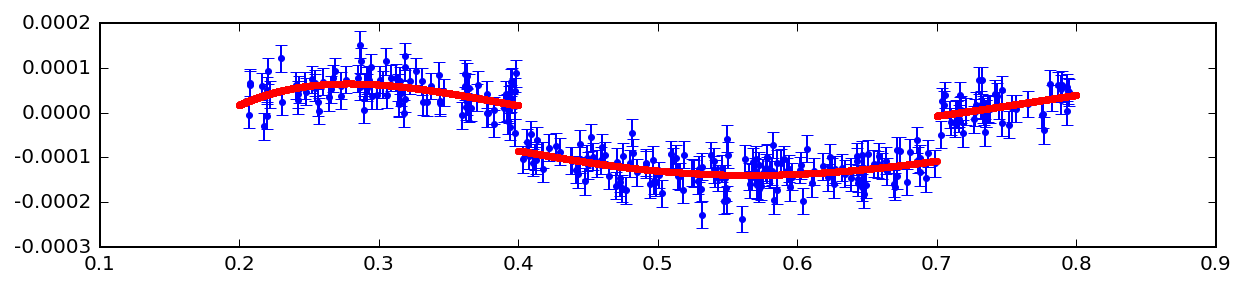

In [3]:
fig, ax = plt.subplots(figsize=(10, 2))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.4f'))
ax.set_xlim(0.1,0.9)
ax.errorbar(time,flujo,yerr= error,fmt='.')
plt.plot(t, y_fit, 'r.')
plt.show()

${\bf c)}$ 

Chi cuadrado: 324.015089186
p-value: 0.102770033833


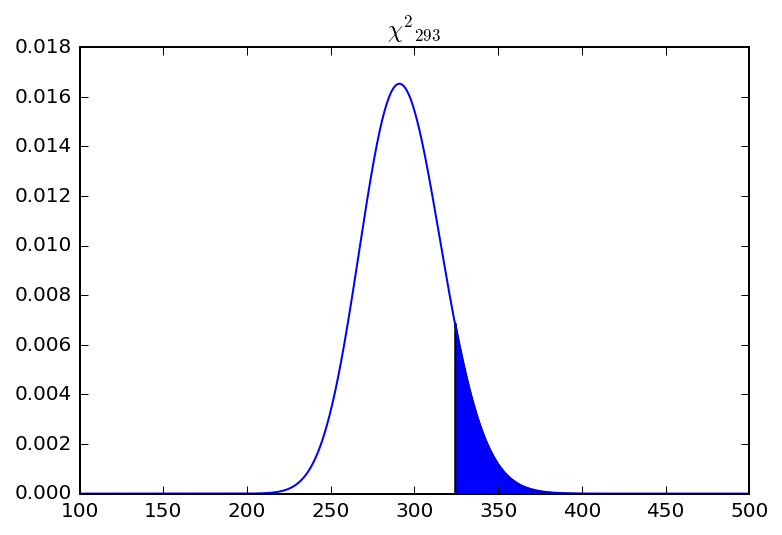

In [4]:
#c) Para hacer un test de chi-cuadrado usaremos la función chi2 de scipy.stats Solo necesitamos los datos 
# y los valores modelados

flux_par = fit(params, coef_matriz)
chi_2, p_value = chi2(flujo,flux_par,293.,error[0])

print 'Chi cuadrado: %s' % chi_2
print 'p-value: %s' % p_value

x = np.linspace(100,500,3000)
y = stats.chi2.pdf(x,293)
plt.title(r'${\chi^2}_{293}$')
plt.fill_between(x[x > chi_2], 0., y[x> chi_2])
plt.plot(x,y)
plt.show()

El valor del p-value es 0.102, lo cual nos dice que tenemos un $\approx 10\%$ de probabilidad de obtener nuestros datos (o unos más extremos) dado que nuestro modelo de tránsito es verdadero.

${\bf 2)}$ 

${\bf a)}$

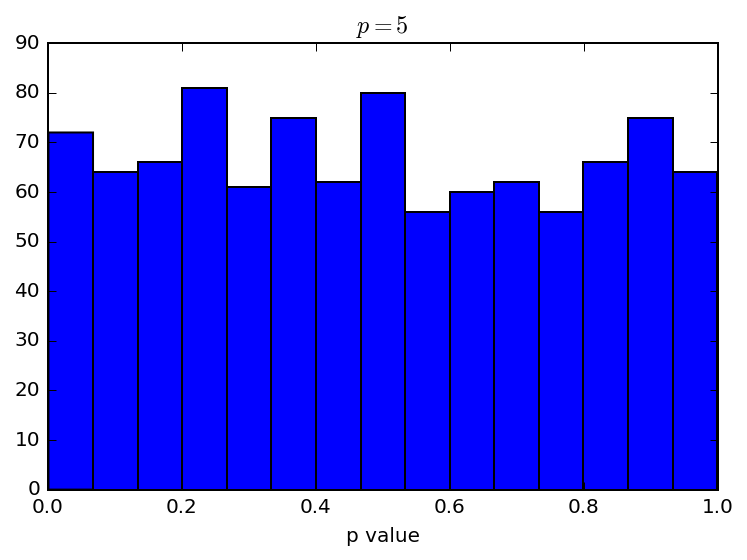

In [5]:
#A simular!

p_values_p5 = []
params_poly_5 = params[1:]

# Caso ajustar polinomio grado 5 a datos provenientes de grado 5 + error
for i in range(1000):
    p = 5 # polinomio
    npoints = 300 # puntos en la simulacion
    
    t = np.linspace(0.2,0.8,npoints)
    std = error[0]

    datos_p5 = simular_pol(params_poly_5, t, std )
    pars_p5, diseno_matrix_p5 = parameters(t,datos_p5,p,'no')
    model_p5= fit(pars_p5,diseno_matrix_p5)

    chi_2_p5, p_value_p5 = chi2(datos_p5, model_p5,npoints - p - 1, std )
    p_values_p5.append(p_value_p5)
    
plt.hist(p_values_p5, 15)
plt.title(r'$p= %s $' %p)
plt.xlabel('p value')
plt.show()

Esto es claramente una distribución uniforme de los p-values. Es sencillo notar que el común uso que se le da a los p-values es incorrecto, ya que estos mismos son variables aleatorias (como hemos mostrado) y no nos $hablan$ sobre la probabilidad de la hipótesis nula ($H_0$), sino que asumimos ésta como verdadera y calculamos la probabilidad de obtener cada set de datos en la simulación dado $H_0$, así que rechazar una hipótesis porque $p < 0.05$ es sumamente aleatorio!

${\bf b)}$

Si la hipótesis nula es cierta (como es en el caso que simulamos datos dado el modelo ($p=5$)), tenemos que al momento de minimizar los mínimos cuadrados, nos encontramos con:

\begin{align}
 S^{2} \propto \sum\limits_{i=1}^{n} \epsilon_i^2 = X_{1}^{2} + X_{2}^{2} + \ldots + X_{n}^{2}
\end{align}

lo cual, sencillamente es la suma de $n$ variables aleatorias ($X^{2}$) que provienen de $X\sim N(0,\sigma^2)$,  s decir, 
${\chi_{n}}^{2}$ con ${\bf exactamente}$ $n$ grados de libertad, o sea, el número total de observaciones. 

Conociendo ya qué significa ${\chi_{\nu}}^{2}$ y $\nu$ en nuestro caso, ahora vamos a ver qué distribución tienen los p-values:

\begin{align}
 \text{p-value} &= \int_{{X_{\nu}}^{2} = x}^{\infty} p_{{X_\nu}^{2}}(\omega)\text{d}\omega \\
                &= 1 - \underbrace{\int_{-\infty}^{x} p_{{X_\nu}^{2}}(\omega)\text{d}\omega}_{{\bf \text{Def. CDF}}} \\
                &= 1 - F(x)
\end{align}

Recordamos ahora la definición de la $\text{probability integral transform}$, lo que nos decía que si $X\sim F$ e $Y = F(X)$, entonces $Y\sim \text{ Uniforme}(0,1)$. En este caso, es claro que $1 - p = F(x) \sim \text{Uniforme}(0,1)$, por tanto $p\sim \text{ Uniforme}(0,1)$. 

${\bf c)}$

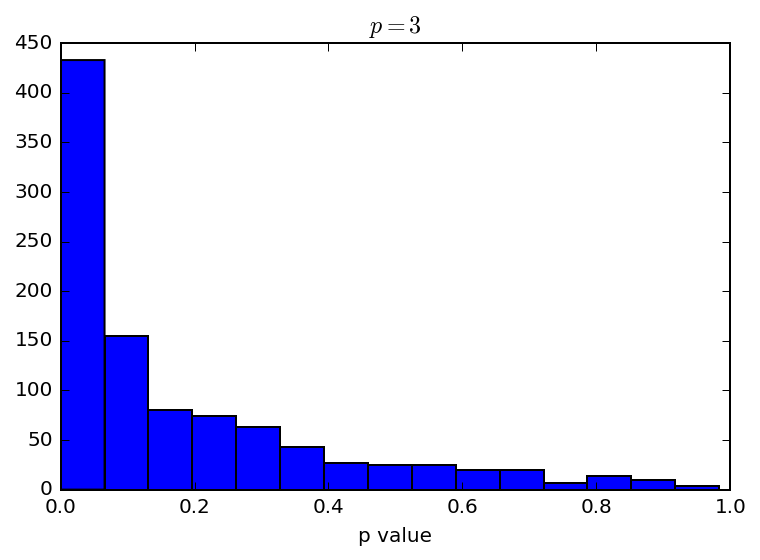

In [6]:
# ahora para un polinomio de grado 3

p_values_p3 = []

for i in range(1000):    
    p = 3 # polinomio
    npoints = 300 # puntos en la simulacion
    
    t = np.linspace(0.2,0.8,npoints)
    std = error[0]

    datos_p3 = simular_pol( params_poly_5, t, std )
    params_p3, diseno_matrix_p3 = parameters(t,datos_p3,p,'no')
    model_p3= fit(params_p3,diseno_matrix_p3)

    chi_2_p3, p_value_p3 = chi2(datos_p3, model_p3,npoints - p - 1, std )
    p_values_p3.append(p_value_p3)
    
plt.hist(p_values_p3, 15)
plt.title(r'$p= %s $' %p)
plt.xlabel('p value')
plt.show()

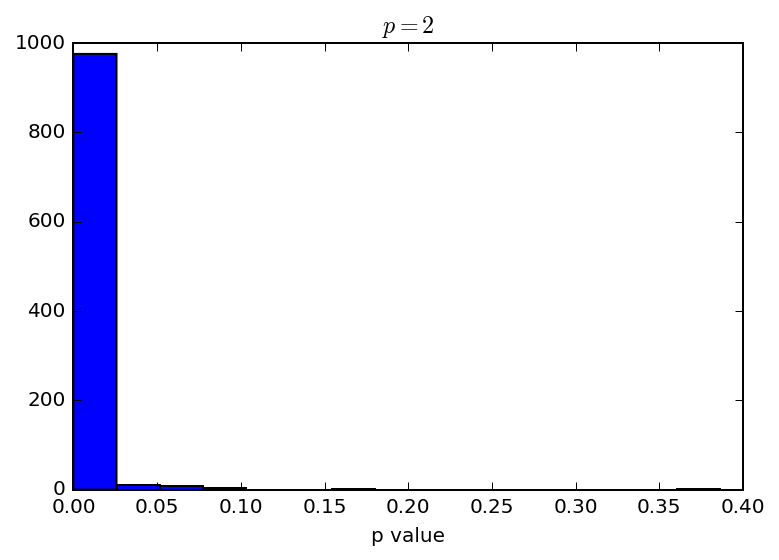

In [8]:
# Ahora para p = 2 (p<<<5)

p_values_p1 = []

for i in range(1000):
    p = 2# polinomio
    npoints = 300 # puntos en la simulacion
    
    t = np.linspace(0.2,0.8,npoints)
    std = error[0]

    datos_p1 = simular_pol( params_poly_5, t, std )
    params_p1, diseno_matrix_p1 = parameters(t,datos_p1,p,'no')
    model_p1= fit(params_p1,diseno_matrix_p1)

    chi_2_p1, p_value_p1 = chi2(datos_p1, model_p1,npoints - p - 1, std )
    p_values_p1.append(p_value_p1)
    
plt.hist(p_values_p1, 15)
plt.title(r'$p= %s $' %p)
plt.xlabel('p value')
plt.show()

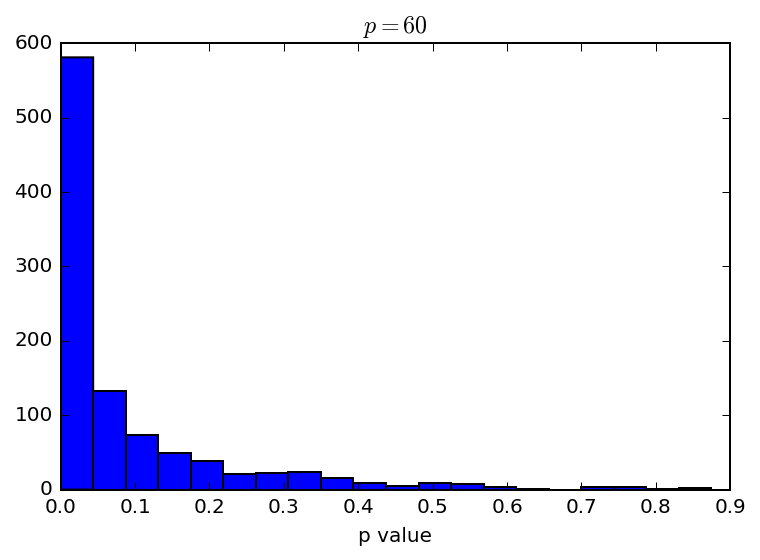

In [11]:
# Ahora para p = 60 (p>>>5)

p_values_palto = []

for i in range(1000):
    p = 60 # polinomio
    npoints = 300 # puntos en la simulacion
    
    t = np.linspace(0.2,0.8,npoints)
    std = error[0]

    datos_palto = simular_pol( params_poly_5, t, std ) 
    params_palto, diseno_matrix_palto = parameters(t,datos_palto,p,'no')
    model_palto= fit(params_palto,diseno_matrix_palto)

    chi_2_palto, p_value_palto = chi2(datos_palto, model_palto, npoints - p - 1, std )
    p_values_palto.append(p_value_palto)
    
plt.hist(p_values_palto, 20)
plt.title(r'$p= %s $' %p)
plt.xlabel('p value')
plt.show()

Vemos que en cada uno de los casos, los p-values están distribuidos mayormente cerca de 0, lo cual es lógico ya que la función generadora es $p=5$. Lo que es muy llamativo, es que también hay probabilidad de encontrar p-values $>0.05$ incluso hasta en $p=60$! O sea, no podríamos rechazar la hipótesis nula de $p=3$ y $p=60$ en $algunos$ casos (es realmente aleatorio!), y solo en casos $muy$ extremos ($p=1$ y/o $p>100$ !), la probabilidad de los datos dado el modelo (p-value) nos dice $\text{con } seguridad$ si podríamos rechazar el modelo (o sea, el p-value no nos da información sobre la hipótesis nula $casi$), pero en la $mayoría$ de los casos no es así.

${\bf d)}$ 

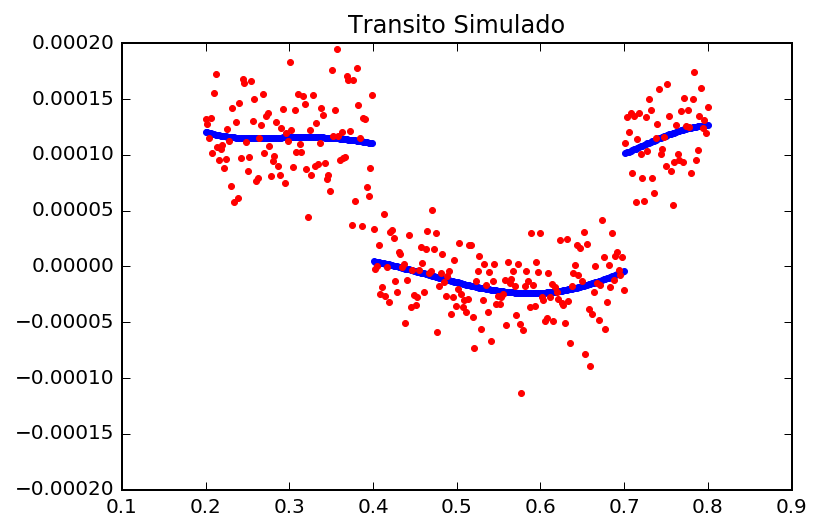

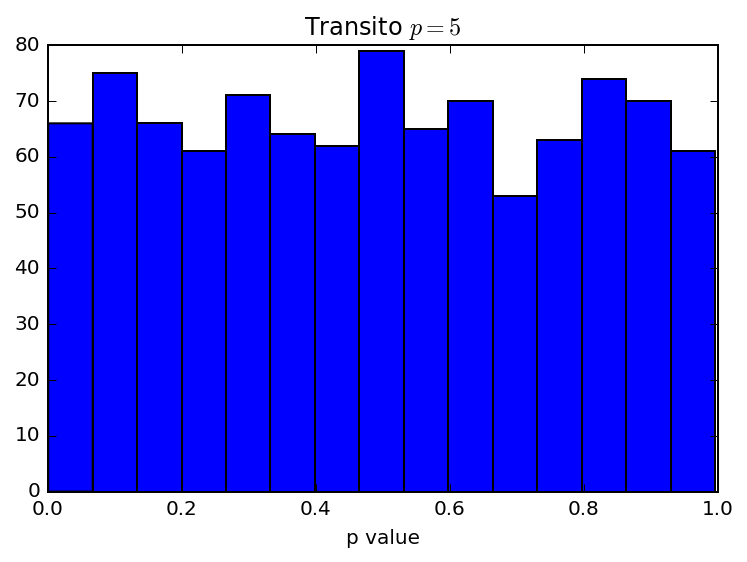

In [12]:
# Ahora para el modelo con tránsito

# Verificar si esta bien simulado
p = 5
t_sim = np.linspace(0.2,0.8,npoints)
std_sim = error[0]
    
datos_sim = simular_transito(params,t_sim,std_sim)

params_sim, diseno_matrix_sim = parameters(t,datos_sim,p,'yes')
model_sim = fit(params_sim,diseno_matrix_sim)

plt.plot(t,model_sim,'b.')
plt.plot(t,datos_sim,'r.')
plt.xlim(0.1,0.9)
plt.ylim(-0.0002,0.0002)
plt.title('Transito Simulado')
plt.show()

p_values_transito = []

for i in range(1000):
    npoints = 300 # puntos en la simulacion
    p = 5
    t = np.linspace(0.2,0.8,npoints)
    std = error[0]
    
    datos_transito = simular_transito(params,t,std)
    params_transito, diseno_matrix_transito = parameters(t,datos_transito,p,'yes')
    model_transito = fit(params_transito,diseno_matrix_transito)
    
    chi_2_transito, p_value_transito = chi2(datos_transito, model_transito, npoints - p - 2, std )
    p_values_transito.append(p_value_transito)    
    
plt.hist(p_values_transito, 15)
plt.title(r'Transito $p= %s $' %p)
plt.xlabel('p value')
plt.show()

Nuevamente, nos topamos con una distribución uniforme de los p-values!. Esto quiere decir, que el resultado del test hecho en a), según el uso que se le da a los p-values normalmente, no podríamos haber rechazado la hipótesis nula (de que el modelo de tránsito es correcto), pero tampoco nos da información $alguna$ de que si es el modelo correcto! (de hecho, en este caso LO ES); peor aún, si nos hubiesen dado otras observaciones simuladas bajo el mismo modelo, y usamos el p-value para rechazarlo o no, ya que la distribución de estos es uniforme, es más probable que lo rechacemos (EL MODELO CORRECTO) a que no lo hagamos! (es totalmente ridículo).

${\bf e)}$

El p-value NO es la probabilidad de que la hipótesis nula sea cierta; es simplemente la probabilidad de obtener datos como los que se obtuvieron (o más extremos) DADO que el modelo es cierto. Los p-values no nos entregan información alguna de cuán bueno es un modelo, ni siquiera comparativamente; el p-value no es una probabilidad que juzga modelos, sino los datos; no tenemos manera de saber si $p = 6$ o $p = 10$ es mejor ya que la probabilidad que representa el p-value, como vimos, es sumamente aleatoria!.

${\bf 3)}$

${\bf a)}$ Recordemos ambos criterios:

\begin{align}
 {\bf AIC} &= -2\log(\mathcal{L}) + 2k + \underbrace{\frac{2k(k+1)}{N - k - 1}}_{\text{para $N$ chico}}\\
 {\bf BIC} &= -2\log(\mathcal{L}) + k\log(N) \\
\end{align}

con $N$ el número de observaciones, $k$ el número de parámetros del modelo y $\mathcal{L}$ el likelihood evaluado en el máximo.

AIC min: [4] 	 BIC min: [4]


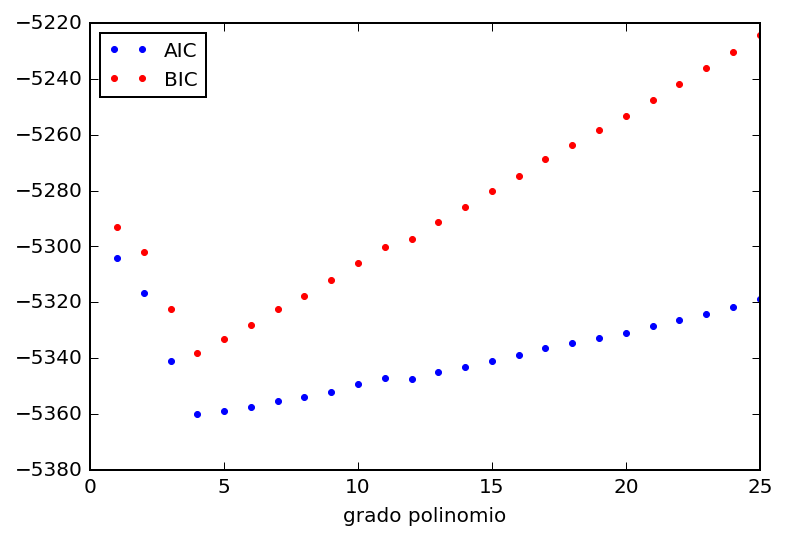

In [13]:
# AIC

#Buscamos fitear polinomios de distinto orden a nuestros datos!

#Comenzamos con p = 1 hasta p = 20
max_order = 25

pol_order = np.arange(1,max_order+1)
AIC = np.zeros(max_order)
BIC = np.zeros(max_order)
AIC_min = 0.
BIC_min = 0.
# I 

for i in range(max_order):
    std = error[0]
    number_par = pol_order[i] + 2.
    dof = len(time) - number_par
    param_i, matrix_i = parameters(time,flujo,pol_order[i],'yes')
    flux_fit = fit(param_i,matrix_i)
    chi_2_i = chi2(flujo, flux_fit, dof, std )[0]
    AIC[i] = chi_2_i + 2.*number_par + 2*len(time)*math.log(math.sqrt(2*math.pi*std**2)) + 2*number_par*(number_par+1)/(len(time) - number_par - 1)
    BIC[i] = chi_2_i + number_par*math.log(len(time)) + 2*len(time)*math.log(math.sqrt(2*math.pi*std**2))
    if AIC_min >= AIC[i]:
       AIC_min = AIC[i]
    if BIC_min >= BIC[i]:
       BIC_min = BIC[i] 
    
print  'AIC min: %s \t BIC min: %s' % (pol_order[np.where(AIC == AIC_min)], pol_order[np.where(BIC == BIC_min)])

#print AIC[0:10]

ax3 = plt.subplot2grid((2,3),(0,0),colspan=3, rowspan=2)
ax3.plot(pol_order,AIC,'b.',label='AIC')
ax3.plot(pol_order,BIC,'r.',label='BIC')

handles, labels = ax3.get_legend_handles_labels()
by_label = collections.OrderedDict(zip(labels, handles))
ax3.legend(by_label.values(), by_label.keys(), loc='upper left',prop={'size':10})
plt.xlabel('grado polinomio')

plt.show()

Claramente, ambos criterios de información arrojan que el grado óptimo sería $p=4$.

${\bf b)}$ El método K-fold cross validation se basa principalmente en que uno particiona su set de observaciones en $k$ particiones (ordenada o aleatoriamente uno extrae puntos en este caso); con $k-1$ particiones uno entrena el modelo (en este caso, calcula los parámetros dado el modelo), y luego, testea el modelo con la partición restante, así $k$ veces, de manera que nunca se repita la partición a testear. 

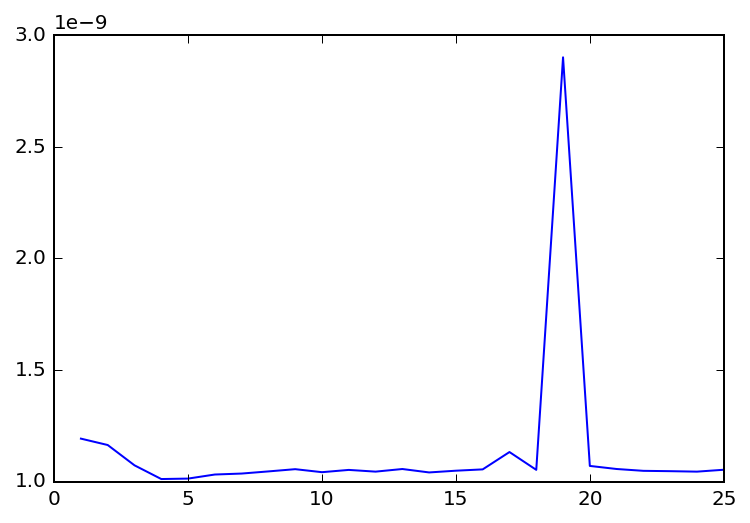

MSE_min p: 4


In [14]:
MSE_p = np.zeros(max_order)
MSE_min = 1000.
folds = 20

for i in range(max_order):
    kf = KFold(300, n_folds=folds, shuffle = True)
    k = 0
    MSE_k = np.zeros(folds)
    
    for train_index, test_index in kf:
        #print train_index, test_index
        time_train, time_test = time[train_index], time[test_index]
        flujo_train, flujo_test = flujo[train_index], flujo[test_index]
    
        #Entrenar
        param_p = parameters(time_train,flujo_train,pol_order[i],'yes')[0]
    
        #Testear
        #creamos la matriz de los nuevos t
        coef_test = coef_matrix(time_test,pol_order[i],'yes')
        # y evaluamos!
    
        flujo_testeado = fit(param_p,coef_test)
    
        MSE_k[k] = np.average( (flujo_testeado-flujo_test)**2)
        #plt.plot(time_test,flujo_test,'r.')
        #plt.plot(time_test,flujo_testeado,'b.') 
        #plt.show()
        k+=1
    
    MSE_p[i] = np.average(MSE_k)  
    if MSE_min >= MSE_p[i]:
       MSE_min = MSE_p[i]
   
plt.plot(pol_order,MSE_p)
plt.show()

print 'MSE_min p: %d' % (pol_order[np.where(MSE_p == MSE_min)])
    



Pero esto, si bien nos da el mismo grado que en a), es bastante arbitrario ya que seteamos $K=20$. Para mostrar que bajo cualquier $K$, si simulamos 100 veces, la moda para cada $K$ será la misma, es decir, $p=4$.

In [15]:

for fold_k in range(2,folds+1):
    MSE_VAL = np.zeros(100) #simulare 100 veces esto para calcular la moda
    for x in range(len(MSE_VAL)):
        MSE_min = 1000.
        for i in range(max_order):
            kf = KFold(300, n_folds=fold_k, shuffle = True)
            k = 0
            MSE_k = np.zeros(fold_k)
            for train_index, test_index in kf:
        #print train_index, test_index
                time_train, time_test = time[train_index], time[test_index]
                flujo_train, flujo_test = flujo[train_index], flujo[test_index]
    
        #Entrenar
                param_p = parameters(time_train,flujo_train,pol_order[i],'yes')[0]
    
        #Testear
        #creamos la matriz de los nuevos t
                coef_test = coef_matrix(time_test,pol_order[i],'yes')
        # y evaluamos!
    
                flujo_testeado = fit(param_p,coef_test)
    
                MSE_k[k] = np.average( (flujo_testeado-flujo_test)**2)
        #plt.plot(time_test,flujo_test,'r.')
        #plt.plot(time_test,flujo_testeado,'b.') 
        #plt.show()
                k+=1
            MSE_p[i] = np.average(MSE_k)  
            if  MSE_min >= MSE_p[i]:
                MSE_min = MSE_p[i]
    #print MSE_min, MSE_p   
        MSE_VAL[x] = pol_order[np.where(MSE_p == MSE_min)]
    print 'MSE_min p: %s with kfold= %d' % (stats.mode(MSE_VAL) ,fold_k)    
        

MSE_min p: ModeResult(mode=array([ 4.]), count=array([31])) with kfold= 2
MSE_min p: ModeResult(mode=array([ 4.]), count=array([30])) with kfold= 3
MSE_min p: ModeResult(mode=array([ 5.]), count=array([29])) with kfold= 4
MSE_min p: ModeResult(mode=array([ 4.]), count=array([37])) with kfold= 5
MSE_min p: ModeResult(mode=array([ 4.]), count=array([37])) with kfold= 6
MSE_min p: ModeResult(mode=array([ 4.]), count=array([39])) with kfold= 7
MSE_min p: ModeResult(mode=array([ 4.]), count=array([47])) with kfold= 8
MSE_min p: ModeResult(mode=array([ 4.]), count=array([51])) with kfold= 9
MSE_min p: ModeResult(mode=array([ 4.]), count=array([50])) with kfold= 10
MSE_min p: ModeResult(mode=array([ 4.]), count=array([55])) with kfold= 11
MSE_min p: ModeResult(mode=array([ 4.]), count=array([56])) with kfold= 12
MSE_min p: ModeResult(mode=array([ 4.]), count=array([59])) with kfold= 13
MSE_min p: ModeResult(mode=array([ 4.]), count=array([65])) with kfold= 14
MSE_min p: ModeResult(mode=array(

${\bf c)}$ El AIC y el BIC, en cuanto a formulación, son bastante parecidos ya que ambos penalizan el $overfitting$ del modelo (el BIC es menos tolerante para $N$ grandes que el AIC ($underfitting$) , mientras que el AIC tiende a $overfitting$ dada la fórmula); $filosóficamente$ no son lo mismo, ya que el AIC no busca encontrar un modelo real, si no cuál es la mínima distancia entre el modelo $real$ (con infinito número de parámetros) y el modelo que aproximamos; en cambio, el BIC busca maximizar la probabilidad posterior de los datos dado el modelo! (el comportamiento asintótico de ambos es distinto por lo mismo). La validación cruzada es un método diferente que busca minimizar alguna medida del MSE (fácil de relacionar con mínimos cuadradros). Su implementación también es muy distinta ya que busca entrenar el modelo con una porción de los datos reales y luego validarlo; teniendo en vista además la capacidad de predecir del modelo (algo que no viene explícitamente en los otros dos criterios de información).